In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
elif torch.backends.mps.is_available():
    dev = "mps"
else:
    dev = "cpu"
device = torch.device(dev)
device

device(type='cuda', index=0)

In [3]:
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

In [4]:
CLASS_TO_IDX = {cls_name: idx + 1 for idx, cls_name in enumerate(VOC_CLASSES)}  # background = 0

In [5]:
# custom transform to prepare target in dict format
class VOCWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img_id = target["annotation"]["filename"]
        boxes = []
        labels = []
        objs = target["annotation"].get("object", [])
        if isinstance(objs, dict):  # single object
            objs = [objs]

        for obj in objs:
            name = obj["name"]
            bbox = obj["bndbox"]
            xmin = int(bbox["xmin"])
            ymin = int(bbox["ymin"])
            xmax = int(bbox["xmax"])
            ymax = int(bbox["ymax"])

            boxes.append([xmin, ymin, xmax, ymax])

            labels.append(CLASS_TO_IDX[name])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.dataset)

In [6]:
# standard normalization values used for ImageNet models
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

In [7]:
input_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

In [8]:
voc_dataset = torchvision.datasets.VOCDetection("./", year='2012', image_set='train', download=True)
voc_wrapped = VOCWrapper(voc_dataset, transforms=input_transforms)
data_loader = DataLoader(voc_wrapped, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to ./


Faster R-CNN with a ResNet50 backbone

In [9]:
# use an ImageNet-pretrained ResNet-50 backbone, train detection head from scratch:
# model = fasterrcnn_resnet50_fpn_v2(weights=None, weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT, min_size=400)

# use COCO-pretrained weights for the detection head (along with pretrained ResNet-50 backbone):
model = fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT, min_size=400)

# replace classifier to match VOC (20 classes + background)
num_classes = 21
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

freeze ResNet backbone

In [10]:
for param in model.backbone.body.parameters():
    param.requires_grad = False

# unfreeze only layer4
for param in model.backbone.body.layer4.parameters():
    param.requires_grad = True

# freeze FPN also
# for param in model.backbone.fpn.parameters():
#     param.requires_grad = False

In [11]:
params = [p for p in model.parameters() if p.requires_grad] # more efficient than including frozen parameters
optimizer = torch.optim.Adam(params, lr=1e-4)

In [12]:
epochs = 10

model.train()
for epoch in range(epochs):
    losses_epoch = 0
    for imgs, targets in data_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        losses_epoch += losses.item()

    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")

Epoch 1, Loss: 1152.2952
Epoch 2, Loss: 903.5116
Epoch 3, Loss: 786.1989
Epoch 4, Loss: 685.2508
Epoch 5, Loss: 606.0208
Epoch 6, Loss: 544.6140
Epoch 7, Loss: 493.7041
Epoch 8, Loss: 457.3110
Epoch 9, Loss: 433.7496
Epoch 10, Loss: 404.5240


In [13]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [14]:
def box_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # left-top
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # right-bottom

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter
    iou = inter / (union + 1e-6)
    return iou

In [15]:
def draw_boxes(ax, boxes, labels, label_map, scores=None, color='lime', score_threshold=0.0):
    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < score_threshold:
            continue

        x1, y1, x2, y2 = box.tolist()
        label = labels[i] - 1 # included background label at index 0
        name = label_map[label] if label < len(label_map) else f"Class {label}"
        score_text = f"{name}: {scores[i]:.2f}" if scores is not None else name

        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       linewidth=2, edgecolor=color, facecolor='none'))
        ax.text(x1, y1 - 5, score_text, fontsize=10, color='black',
                bbox=dict(facecolor=color, alpha=0.5, pad=2))

In [16]:
def plot_predictions_vs_targets(img_tensor, prediction, target, label_map, score_threshold=0.5):
    img_tensor = img_tensor.cpu() * torch.tensor(imagenet_std).view(3, 1, 1) + torch.tensor(imagenet_mean).view(3, 1, 1)
    img = to_pil_image(img_tensor)

    fig, (ax_pred, ax_gt) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle("Predictions vs Ground Truth", fontsize=16)

    # predictions
    ax_pred.imshow(img)
    ax_pred.set_title("Predicted")
    draw_boxes(ax_pred, prediction['boxes'].cpu(), prediction['labels'].cpu(), label_map, scores=prediction['scores'].cpu(), color='lime', score_threshold=score_threshold)
    ax_pred.axis("off")

    # ground truth
    ax_gt.imshow(img)
    ax_gt.set_title("Ground Truth")
    draw_boxes(ax_gt, target['boxes'].cpu(), target['labels'].cpu(), label_map, color='cyan')
    ax_gt.axis("off")

    # IoU calculations
    pred_boxes = prediction['boxes'].cpu()
    pred_labels = prediction['labels'].cpu()
    pred_scores = prediction['scores'].cpu()

    gt_boxes = target['boxes'].cpu()
    gt_labels = target['labels'].cpu()

    if len(pred_boxes) > 0 and len(gt_boxes) > 0:
        ious = box_iou(pred_boxes, gt_boxes)
        best_ious = ious.max(dim=1).values
        valid = pred_scores > score_threshold
        mean_iou = best_ious[valid].mean().item() if valid.any() else 0.0
        iou_text = f"Mean IoU (pred→gt): {mean_iou:.3f} over {valid.sum().item()} boxes"
    else:
        iou_text = "No predictions or ground truth boxes to compute IoU."

    # display IoU info
    fig.subplots_adjust(bottom=0.15)
    fig.text(0.5, 0.01, iou_text, ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

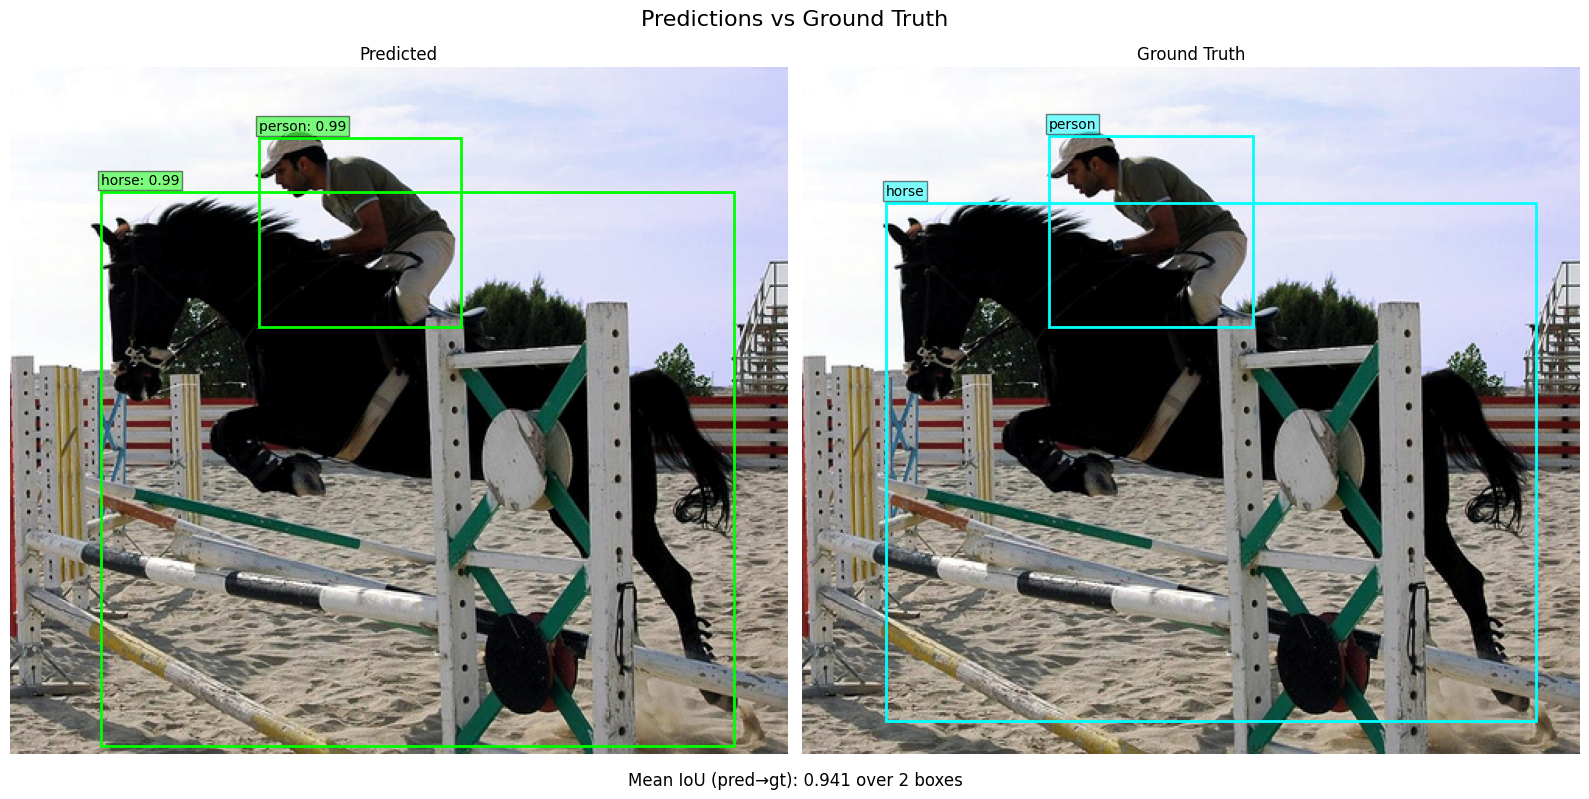

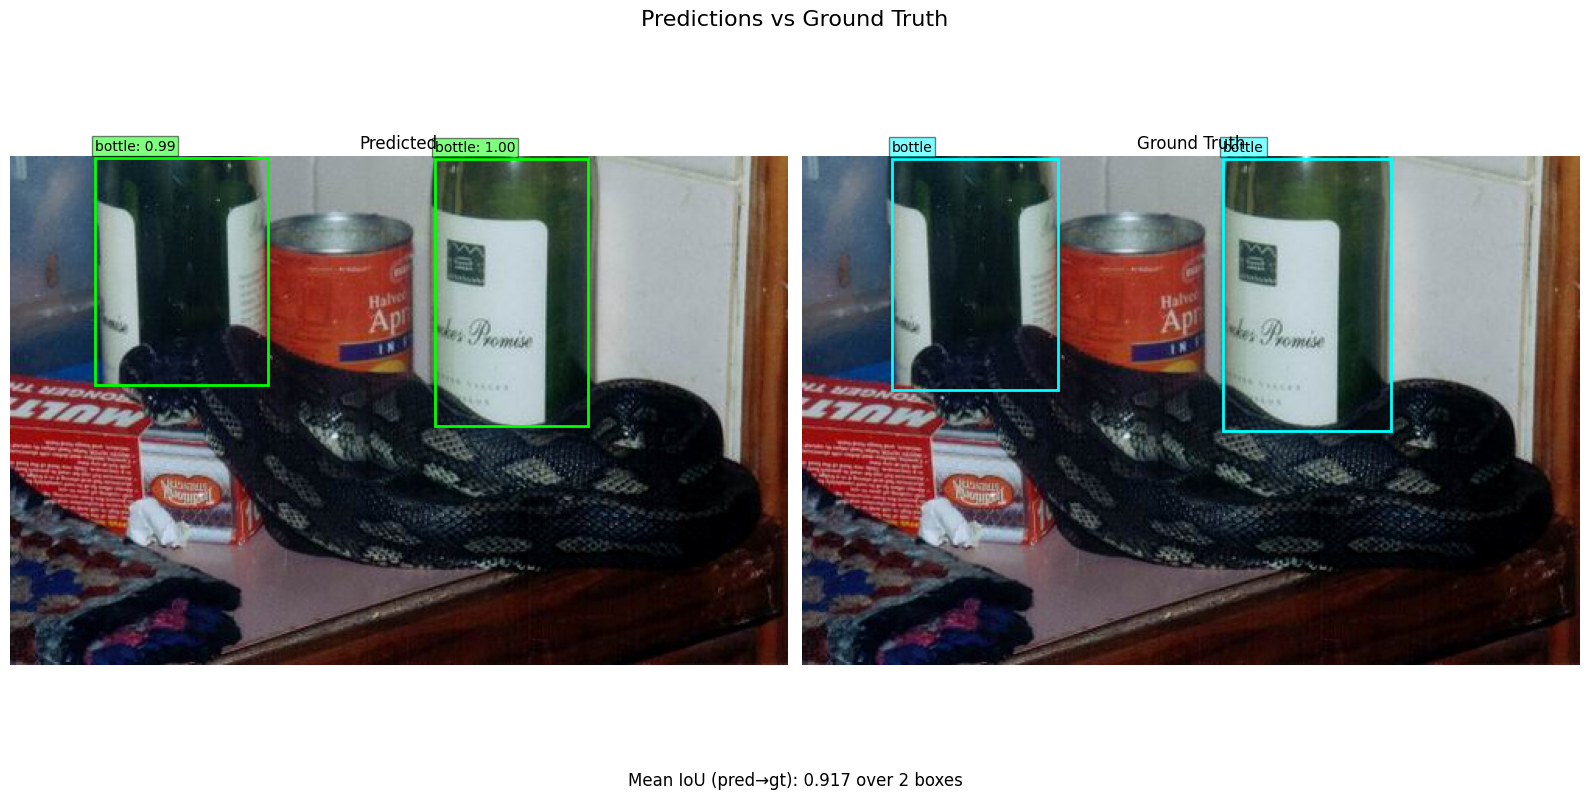

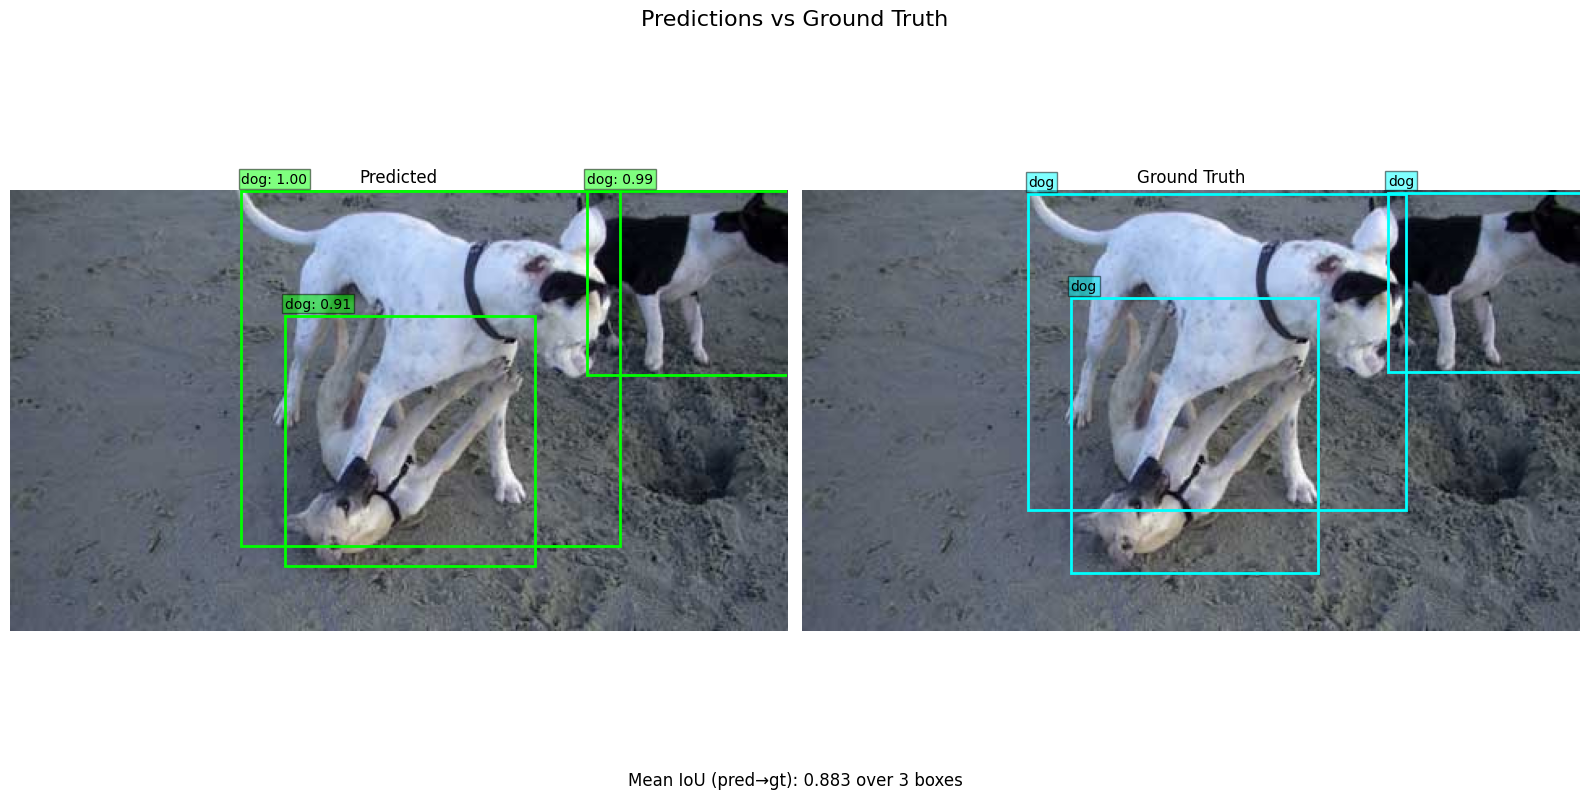

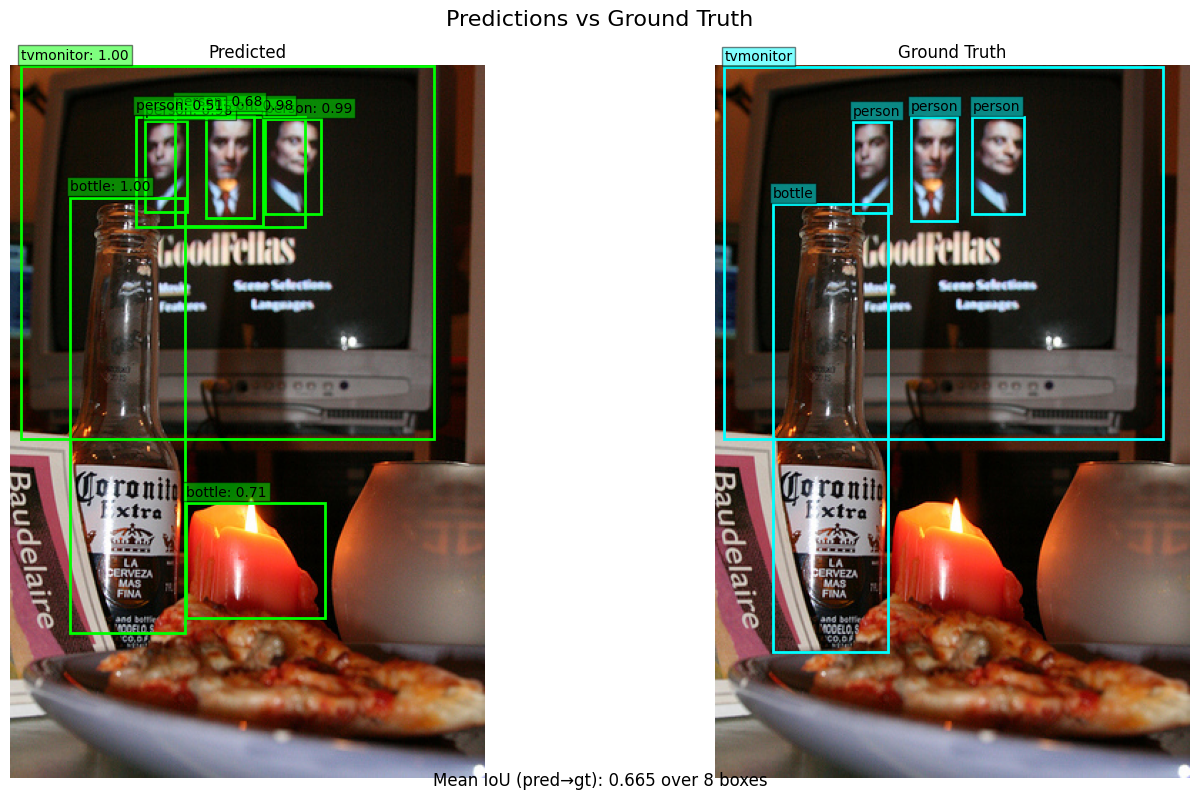

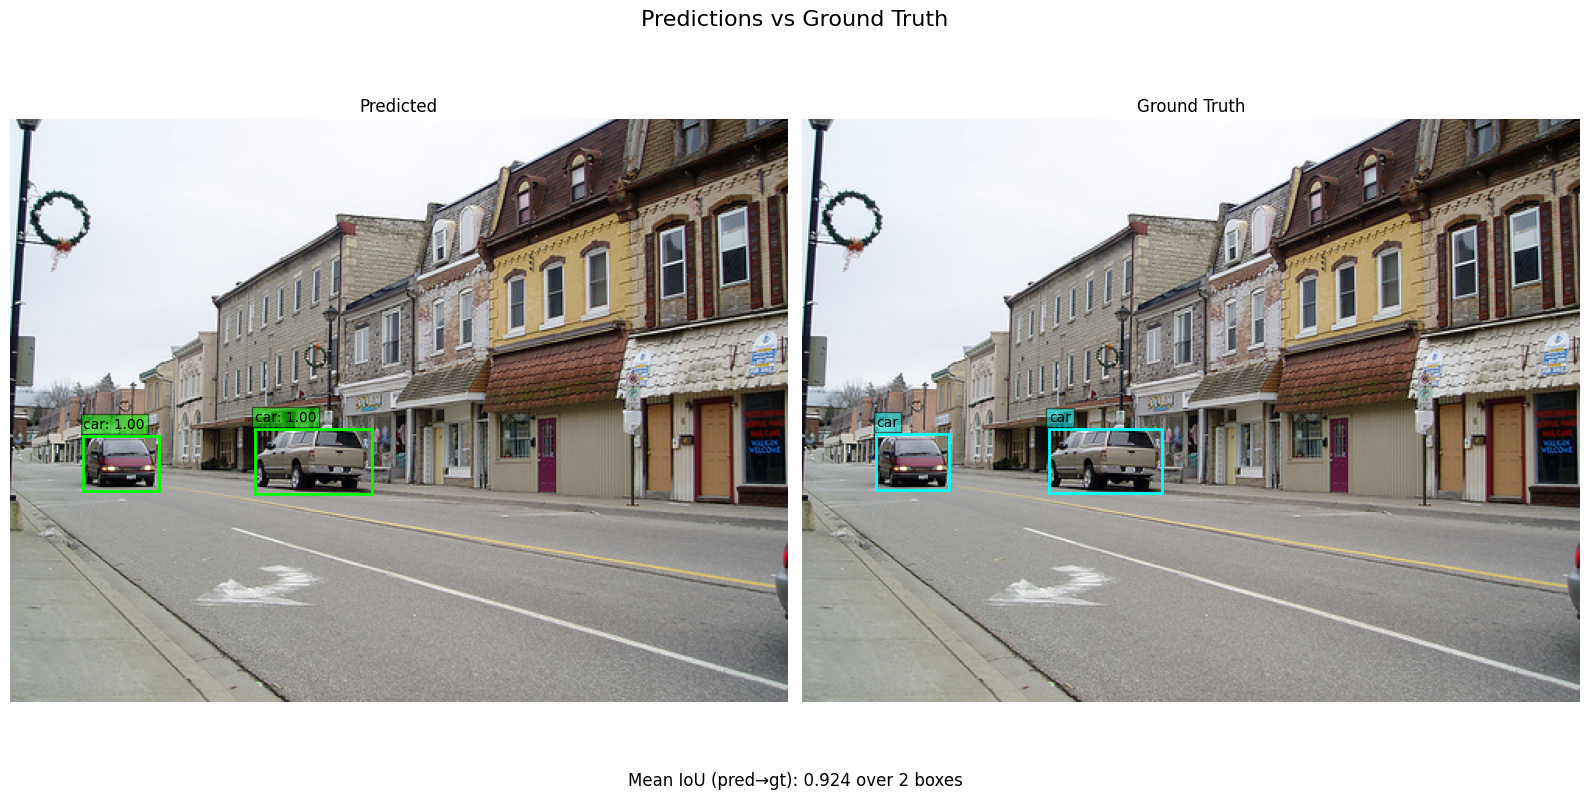

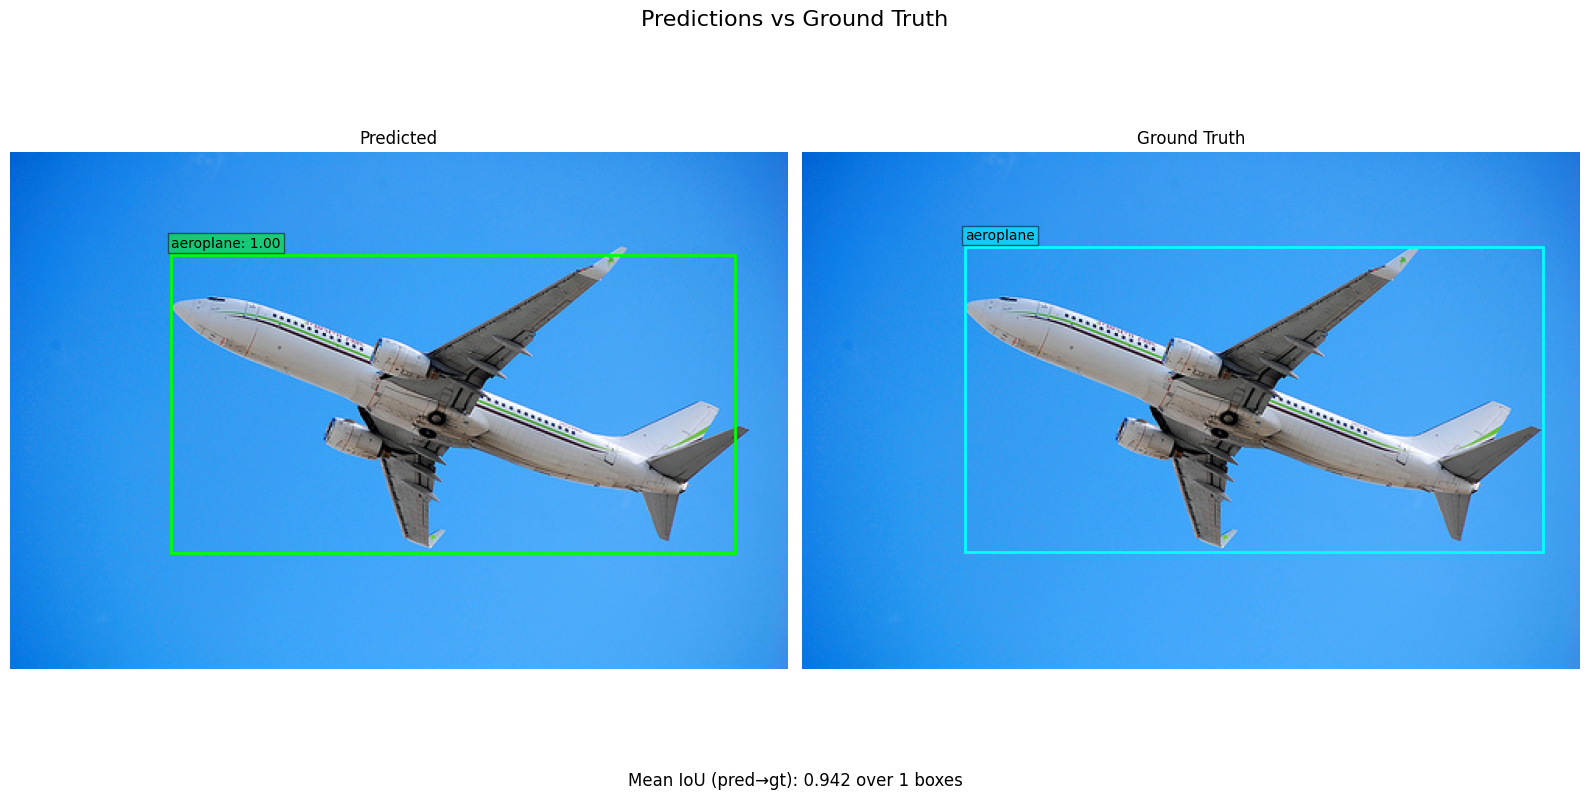

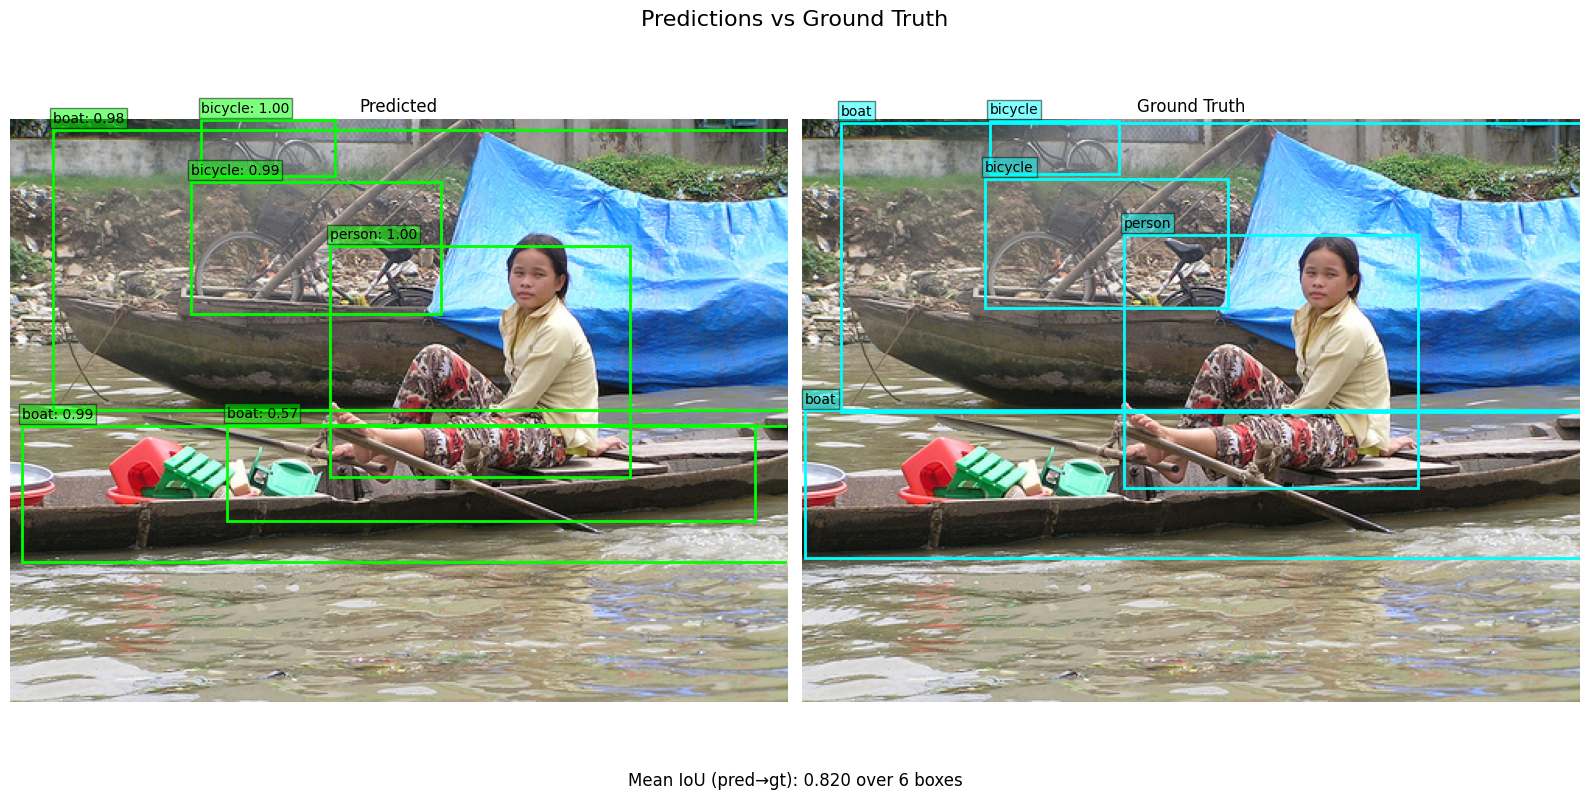

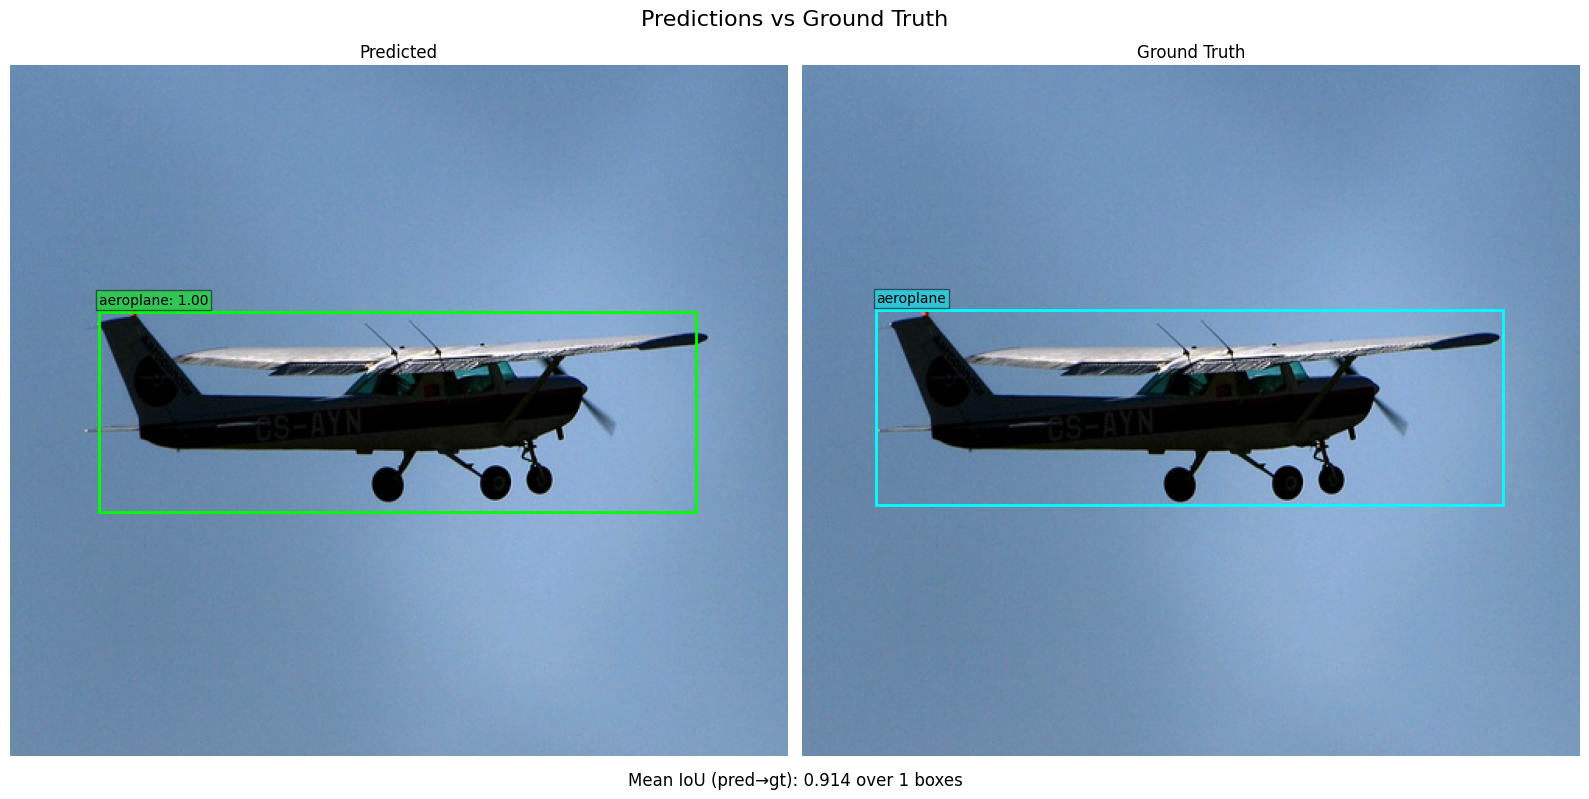

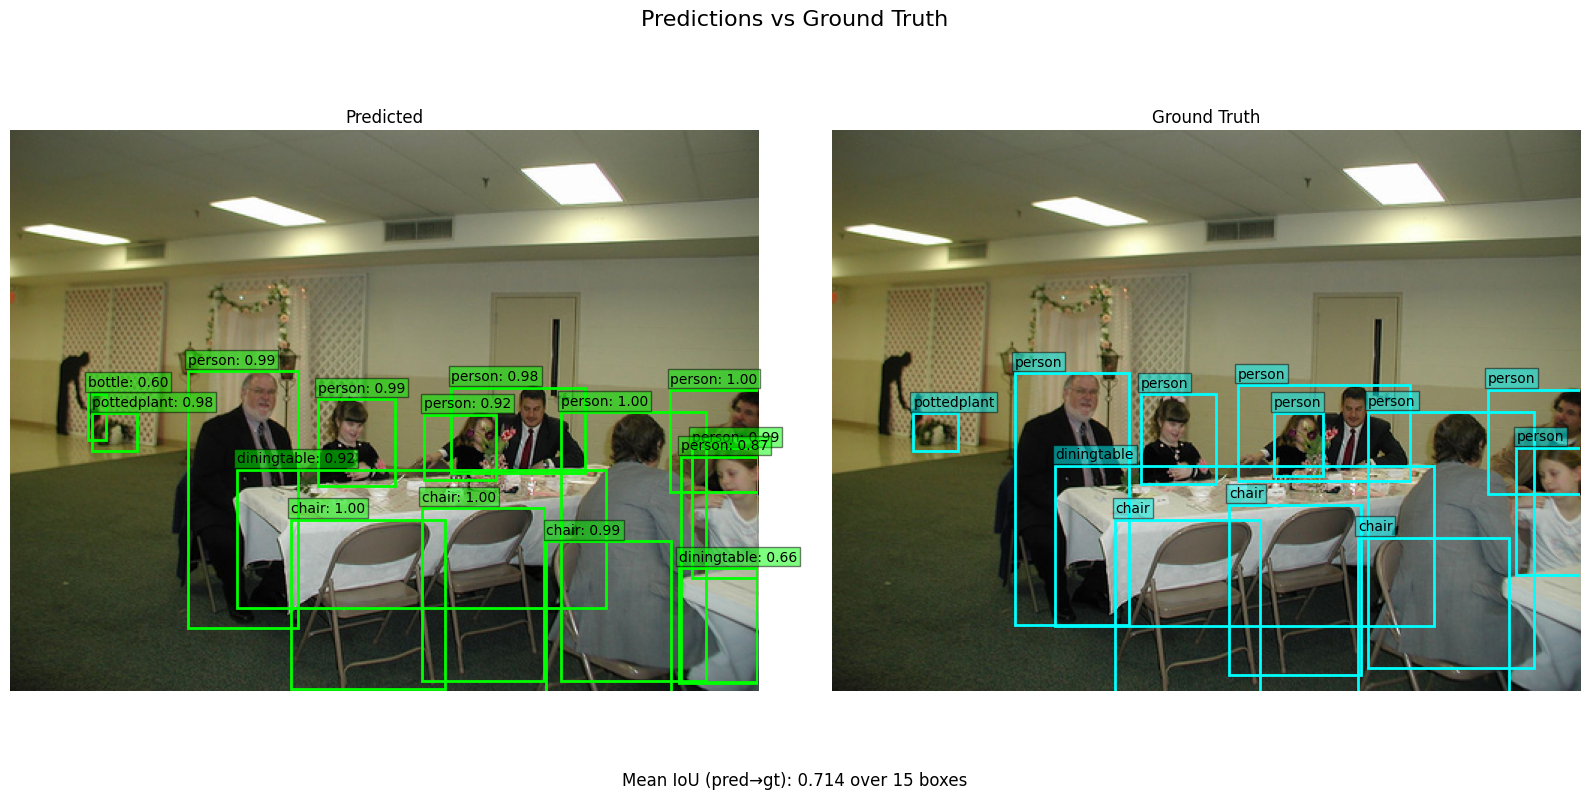

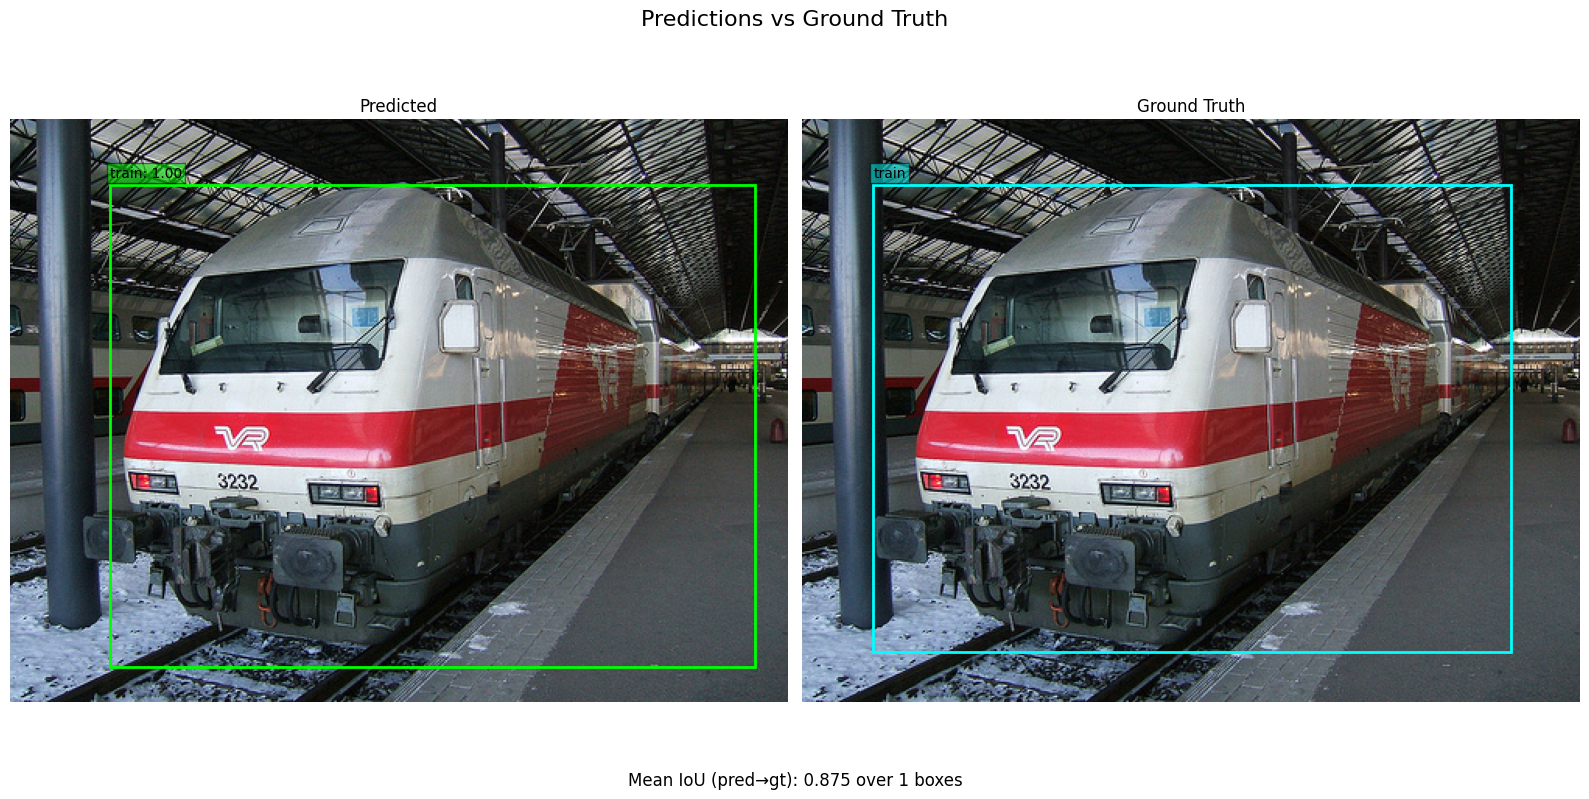

In [17]:
for i in range(10):
    img, target = voc_wrapped[i]
    img = img.to(device)
    with torch.no_grad():
        prediction = model([img])[0]
    plot_predictions_vs_targets(img, prediction, target, VOC_CLASSES)